# <center> Newman on custom trace and user graph </center>

In [1]:
import sys
import util
import numpy as np
import networkx as nx
import random as random
from time import time
from operator import itemgetter
from scipy.special import binom
import matplotlib.pyplot as plt

Load trace.

In [77]:
trace_path = "../Newman/rapportStage/trace_normal.txt"
graph_path = "../Newman/rapportStage/adjList_normal.txt"

Get authors.

In [78]:
Author = util.get_authors(trace_path)

Get users.

In [79]:
users = set(Author.values())
print(users)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}


In [80]:
for i,line in enumerate(open(trace_path)):
    print(line[:-1]) # [:-1] to remove \n at end of line
    if i==5:
        break

1 0.0002320407491522085 51 -1
2 0.0006118585945935823 42 -1
3 0.0007774102808583195 36 -1
4 0.0007851068335115537 50 -1
5 0.0011044432224044177 36 -1
6 0.0013630647560282801 53 -1


Useful function to flatten a list of lists or values from dict of dicts.

In [81]:
def flatten(obj):
    if type(obj) == list:
        return [l for L in obj for l in L]
    if type(obj) == dict:
        return [l for i in obj for l in obj[i].values()]

# example
liste = [[3,5], [0,-7,12], [45]]
print("Example on {} : {}".format(liste, flatten(liste)))
dico = {1: {4:56, 2:45}, 3: {6:32}}
print("Example on {} : {}".format(dico, flatten(dico)))

Example on [[3, 5], [0, -7, 12], [45]] : [3, 5, 0, -7, 12, 45]
Example on {1: {4: 56, 2: 45}, 3: {6: 32}} : [56, 45, 32]


## 1. Initialization

Number of nodes $n$ and list of all node pairs.

In [82]:
n = len(users)
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Fix the value of $\omega$.

In [83]:
# G = nx.read_edgelist(graph_path, nodetype=int, create_using=nx.DiGraph())
# w = np.mean(list(dict(G.out_degree()).values())) / (G.number_of_nodes() - 1)
w = 0.05
print("w = ", w)

w =  0.05


Compute E with maximum value at 30.

In [85]:
# init
E = dict()

# read tweets
for line in open(trace_path):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    
    # if retweet of known author
    if rtid != -1 and rtid in Author:
        rtu = Author[rtid]
        if rtu != uid: # no self-edges
            if uid in E:
                if rtu in E[uid]: # and E[uid][rtu]<30:
                    E[uid][rtu] += 1
                else:
                    E[uid][rtu] = 1
            else:
                E[uid] = {rtu: 1}
print("max E : ", max(flatten(E)))

max E :  22


## 2. Iterations

Function to compute Qij.

In [86]:
def computeQij(w0,a0,b0,nij,eij):
    return (w0 * a0**eij * (1-a0)**(nij-eij)) / (w0 * a0**eij * (1-a0)**(nij-eij) + (1-w0) * b0**eij * (1-b0)**(nij-eij))

Choose parameters.

In [87]:
eps = 10**(-3)
zeroN_prec = 10**(-2)
repetitions = 100
max_iter = 100
verbose = False

Proceed NEW VERSION SPARSE.

In [88]:
# at each repetition we save the values of w, a and b
results = {'N':list(), 'a':list(), 'b':list()}

# Q dict
Q = {i: {j:0 for j in E[i]} for i in E}

start = time()
for k in range(repetitions):
    
    # we may have divisions by zero
    try:
    
        # initialization of the parameters
        N = max(flatten(E)) # the smallest possible value
        a = random.uniform(0.5, 1)
        b = random.uniform(0, 0.5)
        if verbose:
            print("N, a, b = ", N, a, b)
            print()

        # iter
        for l in range(max_iter):
            
            # print state
            sys.stdout.flush()
            sys.stdout.write("repetition {}/{} --- iteration {}/{} --- elapsed time {:.3f}\r"
                             .format(k+1, repetitions, l+1, max_iter, time()-start))

            old_a, old_b, old_N = a, b, N
                    
            # compute Qij and phi
            for i in E:
                for j in E[i]:
                    Q[i][j] = computeQij(w, a, b, N, E[i][j])
            phi = w*n*(n-1) - sum(flatten(Q))
            if verbose:
                print("sum Q = ", sum(flatten(Q)))
                print("phi = ", phi)
                print()
            
            # up N and Q while phi<0
            loop = False # to track if we enter the loop or not
            while phi<0:
                loop = True
                N += 1
                for i in E:
                    for j in E[i]:
                        Q[i][j] = computeQij(w, a, b, N, E[i][j])
                old_phi = phi
                phi = w*n*(n-1) - sum(flatten(Q))
                if verbose:
                    print("N, phi = ", N, phi)
                
            # if we looped then dichotomy to get the best value for N (with precision zeroN_prec)
            if loop:
                N1, N2 = N-1, N
                if verbose:
                    print("\nN1, N2 = ", N1, N2)
                    print()
                while np.abs(phi) > zeroN_prec:
                    N_middle = (N1 + N2) / 2
                    if verbose:
                        print("N_middle = ", N_middle)
                    for i in E:
                        for j in E[i]:
                            Q[i][j] = computeQij(w, a, b, N_middle, E[i][j])
                    phi = w*n*(n-1) - sum(flatten(Q))
                    if phi < 0:
                        N1, N2 = N_middle, N2
                    else:
                        N1, N2 = N1, N_middle
                    if verbose:
                        print("phi = ", phi)
                        print()
                # finally update N
                N = N_middle
            
            # update a,b
            sumQ = sum(flatten(Q))
            a, b = 0, 0
            for i in E:
                for j in E[i]:
                    eij = E[i][j]
                    qij = Q[i][j]
                    a += qij * eij
                    b += (1-qij) * eij
            a /= N * sumQ
            b /= N * (n*(n-1) - sumQ)
            if verbose:
                print("N, a, b = ", N, a, b)
                print()
            
            # break if no sufficient evolution after at least one iteration
            # INCOMPLETE
            new_q = np.array(flatten(Q))
            if l>0 and np.linalg.norm(new_q - old_q, np.inf) < eps:
                if verbose:
                    print("stop because eps")
                break
            
            # register old_q
            old_q = new_q
            
        # add results to results dict
        results['N'].append(N)
        results['a'].append(a)
        results['b'].append(b)
        
    except e:
        print(e)
        continue

Print results.

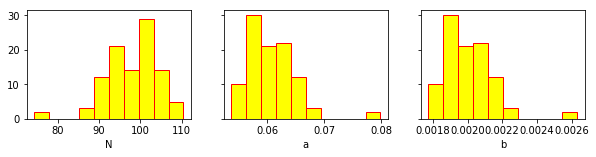

top 5 values for N and proportion
102.825 0.01
102.838 0.01
102.751 0.01
102.671 0.01
103.012 0.01

top 5 values for a and proportion
0.058 0.16
0.059 0.12
0.063 0.09
0.064 0.08
0.06 0.08

top 5 values for b and proportion
0.002 0.98
0.003 0.02

top 5 values for (N,a,b) and proportion
(95.96777, 0.06184, 0.00204) 0.01
(106.93066, 0.0555, 0.00183) 0.01
(106.26855, 0.05584, 0.00184) 0.01
(95.93359, 0.06186, 0.00204) 0.01
(101.5293, 0.05845, 0.00193) 0.01
(93.53516, 0.06345, 0.00209) 0.01
(104.19922, 0.05695, 0.00188) 0.01
(93.17188, 0.0637, 0.0021) 0.01
(101.88867, 0.05825, 0.00192) 0.01
(100.85742, 0.05884, 0.00194) 0.01



In [121]:
# plot the results
plt.rcParams["figure.figsize"] = [10,2]
fig, ax = plt.subplots(1, 3, sharey=True)
for i,(key,values) in enumerate(results.items()):
    values = sorted(values)
    ax[i].hist(values, label=key, facecolor='yellow', edgecolor='red')
    ax[i].set_xlabel(key)
    
plt.show()
plt.close()

# print results
for key,val in results.items():
    print("top 5 values for {} and proportion".format(key))
    val = [round(v,3) for v in val]
    valcount = list()
    for v in set(val):
        valcount.append((v, val.count(v)/len(val)))
    valcount = sorted(valcount, key=itemgetter(1), reverse=True)
    for x in valcount[:5]:
        print(x[0], x[1])
    print()
    
print("top 5 values for (N,a,b) and proportion")
val = list()
for i in range(len(results['N'])):
    val.append((round(results['N'][i],5), round(results['a'][i],5), round(results['b'][i],5)))
valcount = list()
for v in set(val):
    valcount.append((v, val.count(v)/len(val)))
valcount = sorted(valcount, key=itemgetter(1), reverse=True)
for x in valcount[:10]:
    print(x[0], x[1])
print()

Set N,a,b to the most observed values and compute Q accordingly.

N, a, b =  106.26855 0.05584 0.00184


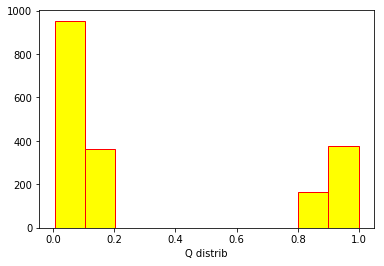

In [150]:
N, a, b = max([(v, val.count(v)/len(val)) for v in set(val)], key=itemgetter(1))[0]
N, a, b = 106.26855, 0.05584, 0.00184

# compute Q
for i in Q:
    for j in Q[i]:
        Q[i][j] = computeQij(w, a, b, N, E[i][j])
        
# plot
print("N, a, b = ", N,a,b)
plt.hist(flatten(Q), facecolor='yellow', edgecolor='red')
plt.xlabel("Q distrib")
plt.show()
plt.close()

## 3. Result analysis

### 3.1 Plots

Plot E/N vs Q.

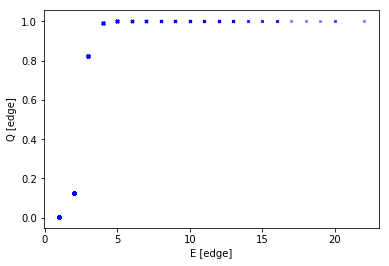

In [151]:
plt.rcParams["figure.figsize"] = [6,4]
x2plot = flatten(E)
y2plot = flatten(Q)
plt.scatter(x2plot, y2plot, color='blue', marker='x', alpha=.5, s=5)
plt.xlabel("E [edge]")
plt.ylabel("Q [edge]")
plt.show()

Get real graph.

In [152]:
G = nx.read_edgelist(graph_path, nodetype=int, create_using=nx.DiGraph())

Compare expected degree.

In [153]:
expected_deg = 2*sum(flatten(Q))/n
var = 4*sum([q*(1-q) for q in flatten(Q)]) / n**2
std = np.sqrt(var)
print("Expected degree observed : {:.3f} with variance {:.3f} and std_dev {:.3f}".format(expected_deg, var, std))
print("Expected degree estimated from real graph : {:.3f}".format(np.mean(G.degree())))

Expected degree observed : 11.244 with variance 0.028 and std_dev 0.167
Expected degree estimated from real graph : 29.450


## 4. Compare real graph, oursin, cascade and Newman

Get oursin graph.

In [154]:
G_oursin = util.nxgraph_from_trace(trace_path, False, Author)
G_cascade = util.nxgraph_from_trace(trace_path, True, Author)

Compare with Newman graph.

In [155]:
print("Mean nb edges in Newman graph : ", 0.5*expected_deg*n)
print("Nb edges in oursin graph : ", G_oursin.number_of_edges())
print("Nb edges in cascade graph : ", G_cascade.number_of_edges())
print("Real nb edges : ", G.number_of_edges())

Mean nb edges in Newman graph :  562.2037786955033
Nb edges in oursin graph :  1879
Nb edges in cascade graph :  1701
Real nb edges :  470


Compare proportion of common edges.

In [156]:
n_samples = 1000
sample_in_real = list()
real_in_sample = list()
sample_in_oursin = list()
oursin_in_sample = list()
sample_in_cascade = list()
cascade_in_sample = list()

# edges lists
oursin_edges = set(G_oursin.edges)
cascade_edges = set(G_cascade.edges)
real_edges = set(G.edges)

for k in range(n_samples):
    
    # sample graph
    G_sample = nx.DiGraph()
    G_sample.add_nodes_from(users)
    for (i,j) in node_pairs:
        if i in Q:
            if j in Q[i] and random.random() < Q[i][j]:
                G_sample.add_edge(j,i)
    sample_edges = set(G_sample.edges)
            
    # compare edges in sample with real graph
    nb_common_edges = len(sample_edges.intersection(real_edges))
    sample_in_real = nb_common_edges / len(sample_edges)
    real_in_sample = nb_common_edges / len(real_edges)
    
    # compare edges in sample with oursin graph
    nb_common_edges = len(sample_edges.intersection(oursin_edges))
    sample_in_oursin = nb_common_edges / len(sample_edges)
    oursin_in_sample = nb_common_edges / len(oursin_edges)
    
    # compare edges in sample with cascade graph
    nb_common_edges = len(sample_edges.intersection(cascade_edges))
    sample_in_cascade = nb_common_edges / len(sample_edges)
    cascade_in_sample = nb_common_edges / len(cascade_edges)
    
# compare oursin and cascade with real
oursin_in_real = len(oursin_edges.intersection(real_edges)) / len(oursin_edges)
real_in_oursin = len(oursin_edges.intersection(real_edges)) / len(real_edges)
cascade_in_real = len(cascade_edges.intersection(real_edges)) / len(cascade_edges)
real_in_cascade = len(cascade_edges.intersection(real_edges)) / len(real_edges)
oursin_in_cascade = len(oursin_edges.intersection(cascade_edges)) / len(oursin_edges)
cascade_in_oursin = len(oursin_edges.intersection(cascade_edges)) / len(cascade_edges)

# print results
print("Mean prop of sample edges that are in real graph : ", np.mean(sample_in_real))
print("Mean prop of real edges that are in sample graph : ", np.mean(real_in_sample))
print()
print("Mean prop of sample edges that are in oursin graph : ", np.mean(sample_in_oursin))
print("Mean prop of oursin edges that are in sample graph : ", np.mean(oursin_in_sample))
print()
print("Mean prop of sample edges that are in cascade graph : ", np.mean(sample_in_cascade))
print("Mean prop of cascade edges that are in sample graph : ", np.mean(cascade_in_sample))
print()
print("Prop of oursin edges that are in real graph : ", oursin_in_real)
print("Prop of real edges that are in oursin graph : ", real_in_oursin)
print()
print("Prop of cascade edges that are in real graph : ", cascade_in_real)
print("Prop of real edges that are in cascade graph : ", real_in_cascade)
print()
print("Prop of oursin edges that are in cascade graph : ", oursin_in_cascade)
print("Prop of cascade edges that are in oursin graph : ", cascade_in_oursin)

Mean prop of sample edges that are in real graph :  0.6565836298932385
Mean prop of real edges that are in sample graph :  0.7851063829787234

Mean prop of sample edges that are in oursin graph :  1.0
Mean prop of oursin edges that are in sample graph :  0.2990952634379989

Mean prop of sample edges that are in cascade graph :  0.701067615658363
Mean prop of cascade edges that are in sample graph :  0.23162845385067607

Prop of oursin edges that are in real graph :  0.24481106971793506
Prop of real edges that are in oursin graph :  0.9787234042553191

Prop of cascade edges that are in real graph :  0.2727807172251617
Prop of real edges that are in cascade graph :  0.9872340425531915

Prop of oursin edges that are in cascade graph :  0.3459286854709952
Prop of cascade edges that are in oursin graph :  0.3821281599059377
